In [129]:
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPool2D, Deconv2D, Cropping2D, UpSampling2D,  Conv2DTranspose
from keras.layers import Input, Add, Dropout, Permute,  LeakyReLU, BatchNormalization, AveragePooling2D, MaxPooling2D
from keras.layers import Dense, Flatten, Activation, Dropout, Embedding, Add,Concatenate,MaxPool2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers.merge import concatenate, add

In [130]:
import os
from tqdm import tqdm_notebook, tnrange
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [131]:
from scipy.io import loadmat
np.random.seed(42)


In [132]:

im_width = 150
im_height = 150
border = 5
path_train = '/Users/olgalavricenko/Documents/DuckData/train/'
path_test = '/Users/olgalavricenko/Documents/DuckData/val'
# Каталог с данными для обучения
train_dir = '/Users/olgalavricenko/Documents/DuckData/train'
# Каталог с данными для проверки
val_dir = '/Users/olgalavricenko/Documents/DuckData/val'
# Каталог с данными для тестирования
test_dir = '/Users/olgalavricenko/Documents/DuckData/val'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 30
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 69972
# Количество изображений для проверки
nb_validation_samples = 1372
# Количество изображений для тестирования
nb_test_samples = 1372


In [133]:
def get_data(path, train=True):
    ids = next(os.walk(path + "image"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        img = load_img(path + '/image/' + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (150, 150, 1), mode='constant', preserve_range=True)

        X[n, ..., 0] = x_img.squeeze() / 256.0
    
        mask = img_to_array(load_img(path + '/segm/' + id_, grayscale=True))
        mask = resize(mask, (150, 150, 1), mode='constant', preserve_range=True)
        y[n] = mask / 256.0
    if train:
        return X, y
    else:
        return X
X, y = get_data(path_train, train=True)


Getting and resizing images ... 


HBox(children=(IntProgress(value=0, max=3001), HTML(value='')))

/Users/olgalavricenko/anaconda3/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [6]:
 #не запускать это для гугл клауда
def get_data(path, train=True):
    ids = next(os.walk(path + "image"))[2]
    X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

    x_img = []
    y_img = []
    img_path = path+'image';

    for filename in os.listdir(img_path):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(img_path, filename))
            img=resize(img, (150,150,1), mode='constant', preserve_range=True)
            if img is not None:
                x_img.append(img)
    #print(x_img)
  #  x_img = resize(x_img, (150, 150, 1), mode='constant', preserve_range=True)

    img_path2 = path+'segm';
    for filename in os.listdir(img_path2):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(img_path2, filename))
            img=resize(img, (150,150,1), mode='constant', preserve_range=True)
            if img is not None:
                y_img.append(img)
    #print(y_img)

   
    if train:
        return X, y
    else:
        return X
X, y = get_data(path_train, train=True)

NameError: name 'cv2' is not defined

In [134]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=2018)

In [135]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

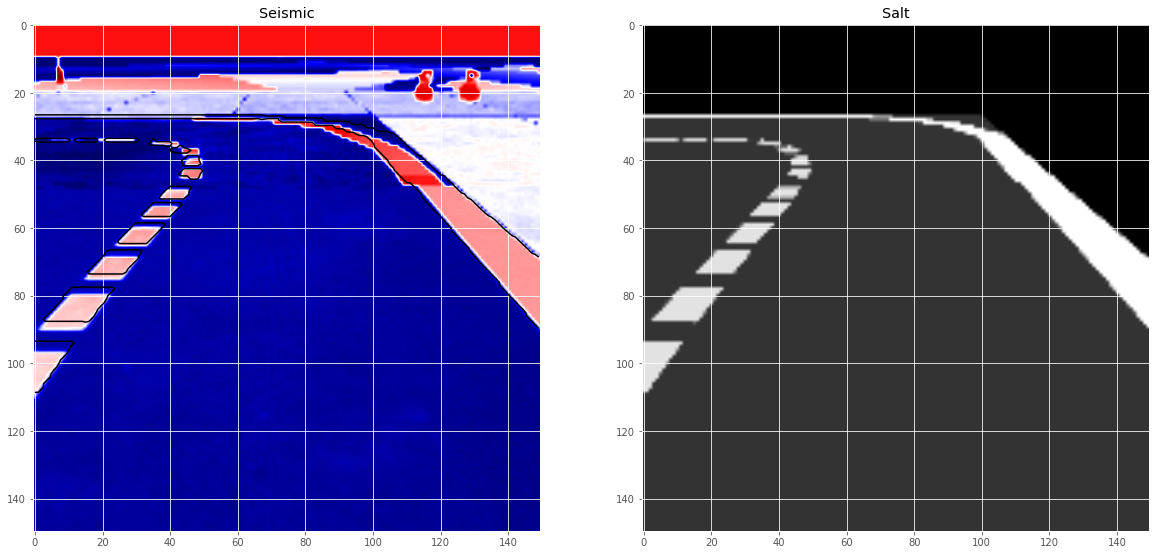

In [136]:
import random

ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')
    ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
    ax[1].set_title('Salt');

In [61]:
def ResConv(kol_kanal , inp ):
    a = Conv2D(kol_kanal,(1,1) ,padding="same", activation="relu" )(inp)
    a = BatchNormalization()(a)
    b = Conv2D(kol_kanal, (3, 3), padding="same", activation="relu")(a)
    b = BatchNormalization()(b)
    c = Conv2D(4*kol_kanal, (1, 1), padding="same", activation=None)(b)
    c = BatchNormalization()(c)
    d = Concatenate()([c,inp])
    e=Activation('relu')(d)
    return e

def ResDeConv( inp ):
    a = UpSampling2D((1,1)  )(inp)
    a = BatchNormalization()(a)
    b = UpSampling2D( (3, 3))(a)
    b = BatchNormalization()(b)
    c = UpSampling2D( (1, 1) )(b)
    
    d=Activation('relu')(c)
    return d

input_shape=(150,150,1)
inp0=Input(input_shape)

model = Sequential()


a = MaxPool2D((3,3),2)(inp0)
skip1 = ResConv(8,a)
a = MaxPool2D((3,3),2)(skip1)
a = ResConv(16,a)
a = MaxPool2D((2,2),2)(a)
a = ResConv(32,a)
a=MaxPool2D((2,2))(a)


a=ResDeConv(a)
a=Conv2D(97,(1,1) ,padding="same", activation="relu" )(a)
a = BatchNormalization()(a)
a=ResDeConv(a)

a=Conv2D(31,(1,1) ,padding="same", activation="relu" )(a)
a=Cropping2D((3,3))(a)
a=UpSampling2D((2,2))(a)
a=Conv2D(1,(1,1),padding="same", activation="sigmoid")(a)


model = Model(inp0, a)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
max_pooling2d_81 (MaxPooling2D) (None, 74, 74, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_268 (Conv2D)             (None, 74, 74, 8)    16          max_pooling2d_81[0][0]           
__________________________________________________________________________________________________
batch_normalization_269 (BatchN (None, 74, 74, 8)    32          conv2d_268[0][0]                 
__________________________________________________________________________________________________
conv2d_269

In [11]:
callbacks = [
EarlyStopping(patience=10, verbose=1),
ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
validation_data=(X_valid, y_valid))

Train on 2550 samples, validate on 451 samples
Epoch 1/100
 992/2550 [==========>...................] - ETA: 6:48 - loss: 0.4679 - acc: 0.2768

In [12]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
validation_data=(X_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 2550 samples, validate on 451 samples
Epoch 1/100
2550/2550 [==============================] - 586s 230ms/step - loss: 1.4658 - acc: 0.2650 - val_loss: 2.2623 - val_acc: 0.2302

Epoch 00001: val_loss improved from inf to 2.26232, saving model to model-tgs-salt.h5
Epoch 2/100
2550/2550 [==============================] - 610s 239ms/step - loss: 0.8476 - acc: 0.2642 - val_loss: 1.2238 - val_acc: 0.2280

Epoch 00002: val_loss improved from 2.26232 to 1.22382, saving model to model-tgs-salt.h5
Epoch 3/100
2550/2550 [==============================] - 595s 233ms/step - loss: 0.7313 - acc: 0.2653 - val_loss: 0.7281 - val_acc: 0.2610

Epoch 00003: val_loss improved from 1.22382 to 0.72812, saving model to model-tgs-salt.h5
Epoch 4/100
2550/2550 [==============================] - 707s 277ms/step - loss: 0.6172 - acc: 0.2693 - val_loss: 0.5656 - val_acc: 0.2696

Epoch 00004: val_loss improved from 0.72812 to 0.56559, saving model to model-t

In [14]:
model_json = model.to_json()
json_file = open("mnist_model.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights("model1.h5")

In [137]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
# first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
    padding="same")(input_tensor)
    
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
    padding="same")(x)
    
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [138]:
def get_unet(input_img, n_filters=16, dropout=0.4, batchnorm=True):
# contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((3, 3)) (c1)
    p1 = Dropout(dropout*0.5)(p1)
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
# expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm) 
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    
  #  u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    
    
 #   u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    u9 = Conv2DTranspose(n_filters*1, (2, 2), strides=(2, 2), padding='same') (c8)
   
    u9 = Conv2DTranspose(n_filters*1, (2, 2), strides=(2, 2), padding='same') (u9)
    u9=Cropping2D(((21,21),(21,21)))(u9)
 
    u9 = concatenate([c1, u9], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [139]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 150, 150, 1)  0                                            
__________________________________________________________________________________________________
conv2d_748 (Conv2D)             (None, 150, 150, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_731 (BatchN (None, 150, 150, 16) 64          conv2d_748[0][0]                 
__________________________________________________________________________________________________
activation_731 (Activation)     (None, 150, 150, 16) 0           batch_normalization_731[0][0]    
__________________________________________________________________________________________________
conv2d_749

In [ ]:
callbacks = [
EarlyStopping(patience=10, verbose=1),
ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
validation_data=(X_valid, y_valid))

Train on 2550 samples, validate on 451 samples
Epoch 1/100
2550/2550 [==============================] - 324s 127ms/step - loss: 0.6967 - acc: 0.1871 - val_loss: 0.5672 - val_acc: 0.2600

Epoch 00001: val_loss improved from inf to 0.56724, saving model to model-tgs-salt.h5
Epoch 2/100
2550/2550 [==============================] - 299s 117ms/step - loss: 0.5556 - acc: 0.2585 - val_loss: 0.5010 - val_acc: 0.2774

Epoch 00002: val_loss improved from 0.56724 to 0.50095, saving model to model-tgs-salt.h5
Epoch 3/100
2550/2550 [==============================] - 284s 111ms/step - loss: 0.4892 - acc: 0.2779 - val_loss: 0.4871 - val_acc: 0.2737

Epoch 00003: val_loss improved from 0.50095 to 0.48709, saving model to model-tgs-salt.h5
Epoch 4/100
2550/2550 [==============================] - 285s 112ms/step - loss: 0.4524 - acc: 0.2820 - val_loss: 0.4456 - val_acc: 0.2814

Epoch 00004: val_loss improved from 0.48709 to 0.44562, saving model to model-tgs-salt.h5
Epoch 5/100
2550/2550 [==============

2550/2550 [==============================] - 294s 115ms/step - loss: 0.3522 - acc: 0.2861 - val_loss: 0.3542 - val_acc: 0.2849

Epoch 00037: val_loss improved from 0.35446 to 0.35420, saving model to model-tgs-salt.h5
Epoch 38/100
2550/2550 [==============================] - 294s 115ms/step - loss: 0.3520 - acc: 0.2861 - val_loss: 0.3538 - val_acc: 0.2849

Epoch 00038: val_loss improved from 0.35420 to 0.35384, saving model to model-tgs-salt.h5
Epoch 39/100
2550/2550 [==============================] - 294s 115ms/step - loss: 0.3518 - acc: 0.2861 - val_loss: 0.3538 - val_acc: 0.2848

Epoch 00039: val_loss improved from 0.35384 to 0.35378, saving model to model-tgs-salt.h5
Epoch 40/100
2550/2550 [==============================] - 295s 116ms/step - loss: 0.3512 - acc: 0.2862 - val_loss: 0.3535 - val_acc: 0.2847

Epoch 00040: val_loss improved from 0.35378 to 0.35351, saving model to model-tgs-salt.h5
Epoch 41/100
2550/2550 [==============================] - 296s 116ms/step - loss: 0.3506 

Epoch 77/100
2550/2550 [==============================] - 292s 114ms/step - loss: 0.3465 - acc: 0.2863 - val_loss: 0.3514 - val_acc: 0.2847

Epoch 00077: val_loss did not improve from 0.35126
Epoch 78/100
2550/2550 [==============================] - 328s 129ms/step - loss: 0.3464 - acc: 0.2863 - val_loss: 0.3513 - val_acc: 0.2847

Epoch 00078: val_loss improved from 0.35126 to 0.35126, saving model to model-tgs-salt.h5
Epoch 79/100
2550/2550 [==============================] - 290s 114ms/step - loss: 0.3464 - acc: 0.2863 - val_loss: 0.3514 - val_acc: 0.2848

Epoch 00079: val_loss did not improve from 0.35126
Epoch 80/100
2550/2550 [==============================] - 296s 116ms/step - loss: 0.3463 - acc: 0.2863 - val_loss: 0.3514 - val_acc: 0.2847

Epoch 00080: val_loss did not improve from 0.35126
Epoch 81/100
2550/2550 [==============================] - 291s 114ms/step - loss: 0.3463 - acc: 0.2863 - val_loss: 0.3512 - val_acc: 0.2847

Epoch 00081: val_loss improved from 0.35126 to 0.351

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
model.load_weights('model-tgs-salt.h5')
model.evaluate(X_valid, y_valid, verbose=1)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))
    has_mask = y[ix].max() > 0
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Road')
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('SegmRoad')
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Road Predicted')
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Road Predicted binary');

In [ ]:
for (i in range (10,20)){
    plot_sample(X_train, y_train, preds_train, preds_train_t, ix=i)
}


In [102]:
images_per_row = 16
n_filters = activation.shape[-1]
size = activation.shape[1]
n_cols = n_filters // images_per_row

display_grid = np.zeros((n_cols * size, images_per_row * size))

for col in range(n_cols):
    for row in range(images_per_row):
        channel_image = activation[0, :, :, col * images_per_row + row]
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

scale = 1. / size
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
plt.grid(False)
plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: name 'activation' is not defined